# Train classifier to estimate analysis efficiency vs gen variable

- Actual training code in training.py
- Classifier based on sklearn. Default is GradientBoostedClassifier, 
    but can be specified at run time.

## Load libraries

In [1]:
import train as tn
reload(tn)

import plotting
reload(plotting)

import matplotlib.pyplot as plt
#plt.style.use('seaborn-ticks')
plt.style.use('seaborn-poster')
%matplotlib inline
#%matplotlib notebook

import numpy as np

from pprint import pprint

Welcome to ROOTaaS 6.06/08


## Instantiate helper class

Data are read from ROOT trees and converted into pandas data frames.  
The loading function makes sure that all the needed columns have been read from the trees, otherwise it rebilds the data frame.


In [2]:
madeinputDir="/eos/user/m/musella/data/mod_dep_005"
inputDir="root://t3dcachedb03.psi.ch//pnfs/psi.ch/cms/trivcat/store/user/musella/mod_dep_005"
fname = inputDir+"/output_InsideAcceptance_125.root"
pfx = "genDiphotonDumper/trees/InsideAcceptance_125_13TeV"

ncats = 3
genBranches = ["genPt","genRapidity",
            "genJet2p5Pt0","genJet2p5Rapidity0",
            "genJet2p5Pt1","genJet2p5Rapidity1",
            "genJet2p5Pt2","genJet2p5Rapidity2",
            "genJet2p5Pt3","genJet2p5Rapidity3",
            "weight",
            "genNjets2p5"
           ]
recoBranches = ['recoPt','recoRapidity',"recoNjets2p5"]
rndseed = 9347865
rndseed2 = 2315645

split_params = {"train_size" : 0.75, "test_size" : 0.25, "random_state" : rndseed2, "stratify" : False }

def loadOrMake(name,load,forceMake):
    
    make = False
    if load:
        onDisk = tn.IO.load(name, nodata=forceMake)
        pprint(onDisk)
        if not forceMake:
            pprint(onDisk.df.columns)
        pprint(onDisk.clfs)
        if onDisk.genBranches != genBranches or onDisk.recoBranches != recoBranches:
            make = True
        if onDisk.ncats != ncats:
            make = True
            load = False
    else:
        make = True

    if make or forceMake:
        if not load:
            made = tn.EfficiencyFitter(name)
        else:
            made = onDisk
        
        made.readData(ncats,genBranches,recoBranches,[(fname,None,pfx)])
        
        print('shuffling dataset')
        np.random.seed(rndseed)
        made.df['random_index'] = np.random.permutation(range(made.df.index.size))
        made.df.sort_values(by='random_index',inplace=True)
        made.df.set_index('random_index',inplace=True)
        made.split_params = split_params
        
        print('defining bins')
        if not 'absGenRapidity' in made.df.columns:
            made.df['absGenRapidity'] = np.abs(made.df['genRapidity'])
        made.defineBins('recoPt',boundaries=[0,15,30,60,120,180,200])
        made.defineBins('recoNjets2p5',boundaries=[-0.5,1.5,2.5,3.5,4.5,5.5])
        
        
    else:
        made = onDisk
        
    return made

effFitter = loadOrMake('effFitter',True,False)
# effFitter.defineBins('recoNjets2p5',boundaries=[-0.5,1.5,2.5,3.5,4.5,5.5])
# rndseed = 9347865
# np.random.seed(rdnseed)
# effFitter.df.reindex(np.random.permutation(effFitter.df.index))

loading pickle ./effFitter.pkl.gz
loading data ./effFitter.root
Index([u'absweight', u'class', u'genJet2p5Pt0', u'genJet2p5Pt1',
       u'genJet2p5Pt2', u'genJet2p5Pt3', u'genJet2p5Rapidity0',
       u'genJet2p5Rapidity1', u'genJet2p5Rapidity2', u'genJet2p5Rapidity3',
       u'genNjets2p5', u'genPt', u'genRapidity', u'recoNjets2p5', u'recoPt',
       u'recoRapidity', u'weight', u'absGenRapidity', u'recoPtBin',
       u'recoPtCat', u'recoNjets2p5Bin', u'recoNjets2p5Cat', u'class_prob_0',
       u'class_prob_1', u'class_prob_2', u'class_prob_3', u'recoPtCat_prob_0',
       u'recoPtCat_prob_1', u'recoPtCat_prob_2', u'recoPtCat_prob_3',
       u'recoPtCat_prob_4', u'recoPtCat_prob_5', u'recoPtCat_prob_6',
       u'recoPtCat_prob_7', u'recoPtCat_prob_8', u'recoPtCat_prob_9',
       u'recoPtCat_prob_10', u'recoPtCat_prob_11', u'recoPtCat_prob_12',
       u'recoPtCat_prob_13', u'recoPtCat_prob_14', u'recoPtCat_prob_15',
       u'recoPtCat_prob_16', u'recoPtCat_prob_17', u'recoPtCat_prob_18',


In [3]:
effFitter

## Train classifier for selection category and $p_{T}$

In [ ]:
#recoPts = filter(lambda x: "recoPt_prob" in x, effFitter.df.columns)
#rename = { x : x.replace("_prob","Cat_prob") for x in recoPts }
#effFitter.df.rename(columns=rename,inplace=True)

In [ ]:
if not 'class' in effFitter.clfs:
    effFitter.fitClass(trainevts=100000,
                       max_depth=5,learning_rate=0.2,n_estimators=100,min_weight_fraction_leaf=1e-3)
    
if not 'recoPt' in effFitter.clfs:
    effFitter.split = None
    effFitter.fitBins('recoPt',['genPt','absGenRapidity'],
                      trainevts=100000,max_depth=7,learning_rate=0.1,n_estimators=500,min_weight_fraction_leaf=1e-4)

In [ ]:
## clf_keys = effFitter.clfs.keys()
## clf_keys = filter(lambda x: x=='class', clf_keys)+filter(lambda x: x!='class', clf_keys)

clf_keys = ['class','recoPtCat']#,'recoNjets2p5Cat']

for x in filter(lambda y: "CatCat" in y, effFitter.df.columns):
    del effFitter.df[x]

for key in clf_keys:
    catKey = '%s_prob_0' % key
    if not catKey in effFitter.df.columns:
        print('running prediction for %s' % key)
        effFitter.runPrediction(key,effFitter.clfs[key.replace("Cat","")])


effFitter.df.columns

In [ ]:
# save output to avoid re-runnig the heavy calculations above
tn.IO.save(effFitter)

In [ ]:
## from pandas.tools import plotting
## 
## group_by_class = effFitter.df.groupby('class')
## plotting.scatter_matrix(effFitter.df[['class_prob_0','class_prob_1','class_prob_2','class_prob_3']],figsize=(14,8))

In [ ]:
class_grid,class_eff_map = effFitter.effMap('class',[(300,0,300),(300,0,3.)])
recoPt_grid,recoPt_eff_map = effFitter.effMap('recoPt',np.hstack([class_grid,class_eff_map]))

In [ ]:
plotting.efficiency_map(class_grid[:,1],class_grid[:,0],class_eff_map,figsize=(14,8),xlabel="|y|",ylabel="p_T",
                        layout=(3,None))

plt.subplots_adjust(hspace = 0.25, wspace = 0.3, top=0.88)

In [ ]:
import plotting
reload(plotting)

plotting.efficiency_map(recoPt_grid[:,1],recoPt_grid[:,0],recoPt_eff_map,figsize=(35,25),xlabel="|y|",ylabel="p_T",
                       layout=(3,None))

plt.subplots_adjust(hspace = 0.25, wspace = 0.1, top=0.93)

In [ ]:
resummed = np.array(map(lambda y: recoPt_eff_map[:,y].sum(), map(lambda x: range(x+1,22,3), range(3)) )).transpose()
classwise = class_eff_map[:,1:].sum(axis=0)

resummed / classwise

In [ ]:
resummed.sum() / classwise.sum()

In [ ]:
#group_by_class.plot(kind='hexbin',y='class_prob_0',x='class_prob_1',C='weight',table=True,layout=(2,2))
#group_by_class.plot(kind='hexbin',y='class_prob_1',x='class_prob_2',C='weight',layout=(2,2))
#,C='weight',subplots=False

In [ ]:
#help(group_by_class)

In [ ]:
effFitter.df.columns

In [ ]:
df = effFitter.df

In [ ]:
allcols = filter(lambda x: "class_prob_" in x and not "prob_0" in x, df.columns)+["class_prob_0"]

effFitter.df.boxplot(by='class',column=allcols,figsize=(14,8),layout=(2,3))

In [ ]:
reload(plotting)
plotting.scatter_hist(df,allcols,figsize=(28,28))

In [ ]:
(df['recoPtCat_prob_0']-df['class_prob_0']).describe()

In [ ]:
plt.figure(figsize=(14,8))
plt.hexbin(y=df['recoPtCat_prob_0'], x=df['class_prob_0'],cmap=plt.cm.Blues)
plt.ylabel('recoPtCat_prob_0')
plt.xlabel('class_prob_0')
plt.colorbar()

In [ ]:
allcols = filter(lambda x: "recoPtCat_prob_" in x and not "prob_0" in x, df.columns)+['recoPtCat_prob_0']

effFitter.df.boxplot(by='recoPtCat',column=allcols,figsize=(28,28),layout=(8,3))

In [ ]:
plotting.scatter_hist(df[:30000],allcols,figsize=(28,28),log=True)

In [ ]:
effFitter.df

In [5]:
#reload(tn)
#if not 'recoNjets2p5' in effFitter.clfs:
if True:
    effFitter.split_params={}
    # effFitter.defineBins('recoNjets2p5',boundaries=[-0.5,1.5,2.5,3.5,4.5])
    effFitter.split = None
    effFitter.fitBins('recoNjets2p5',[
            'genJet2p5Pt0', 'genJet2p5Rapidity0',
            'genJet2p5Pt1', 'genJet2p5Rapidity1',
            'genJet2p5Pt2', 'genJet2p5Rapidity2',
            'genJet2p5Pt3', 'genJet2p5Rapidity3',
            'genPt','absGenRapidity'
            ],#factorized=True,
            trainevts=500000,max_depth=5,learning_rate=0.1,n_estimators=100,min_weight_fraction_leaf=1e-4,
                      subsample=0.1,verbose=True,
                     )
    

cvoptimize False
      Iter       Train Loss      OOB Improve   Remaining Time 
         1      143355.8195      -11478.0333           69.94m
         2      144282.8560       -8364.2471           69.80m
         3      145119.3097       -7556.7531           68.68m
         4      145927.1634       -7281.8078           67.60m
         5      146705.7142       -6951.0148           66.91m
         6      147423.3380       -6553.9829           65.62m
         7      148135.0252       -6281.0176           63.91m
         8      148790.1948       -5955.6400           62.61m
         9      149367.6447       -5323.9332           61.36m
        10      149928.3224       -5012.2596           60.08m
        20      153994.3646       -2192.3283           49.14m
        30      155506.6150        -830.2771           41.08m
        40      156309.1825           0.0000           34.08m
        50 367948074966.3074           0.0000           27.79m
        60 9369992985812275199801584156559080371434

In [6]:
effFitter.clfs
## from pandas.tools import plotting
## 
## group_by_class = df.groupby('recoPtCat')
## recoPtCatProbs = filter(lambda x: 'recoPtCat_prob' in x, df.columns)
## plotting.scatter_matrix(df[recoPtCatProbs],figsize=(28,16))

{'class': GradientBoostingClassifier(init=None, learning_rate=0.2, loss='deviance',
               max_depth=5, max_features=None, max_leaf_nodes=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.001, n_estimators=100,
               presort='auto', random_state=None, subsample=1.0, verbose=1,
               warm_start=False),
 'recoNjets2p5': GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
               max_depth=5, max_features=None, max_leaf_nodes=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0001, n_estimators=100,
               presort='auto', random_state=None, subsample=0.1,
               verbose=True, warm_start=False),
 'recoPt': GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
               max_depth=7, max_features=None, max_leaf_nodes=None,
               min_samples_leaf=1, min_samples_split=2,
              

In [14]:
#effFitter.name = 'effFitter_test'
tn.IO.save(effFitter)

In [ ]:
allcols = filter(lambda x: "recoNjets2p5Cat_prob_" in x and not "prob_0" in x, df.columns)+['recoNjets2p5Cat_prob_0']

effFitter.df.boxplot(by='recoNjets2p5Cat',column=allcols,figsize=(28,28),layout=(8,3))

In [ ]:
plotting.scatter_hist(df,allcols,figsize=(28,28),log=True)

In [ ]:
effFitter.clfs['recoNjets2p5'].inputs

In [ ]:
#tn.IO.save(effFitter)

In [ ]:
effFitter.df.columns

In [ ]:
plt.figure(figsize=(14,8))
plt.hexbin(y=df['recoNjets2p5Cat_prob_0'], x=df['class_prob_0'],cmap=plt.cm.Blues)
plt.ylabel('recoNJets2p5Cat_prob_0')
plt.xlabel('class_prob_0')
plt.colorbar()

In [ ]:
#effFitter.df.plot(kind='hexbin',y='recoNjets2p5Cat_prob_0',x='genJet2p5Pt1')

In [12]:
def naive_closure(df,column,pred_postfix="",first=0,logy=False):
    nstats = np.unique(df[column]).size
    
    pred_cols = map(lambda x: ("%s%s_prob_%d" % (column, pred_postfix, x)), range(nstats) ) 
    
    trueh = np.histogram(df[column],np.arange(-1.5,nstats-0.5))[0].ravel()
    predh = np.array(df[pred_cols].sum(axis=0)).ravel()
    
    print(trueh,predh)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    true = ax.bar(np.arange(0,2*(nstats),2)[first:],trueh[first:],color='black')
    pred = ax.bar(np.arange(1,2*(nstats)+1,2)[first:],predh[first:],color='red')
    if logy:
        ax.set_yscale('log')
        
    plt.legend((true,pred),("true","predicted"))
    
    plt.show()

(array([558201, 199025, 239432, 392746]), array([ 556076.19347136,  200648.41642943,  240308.16578402,
        392371.22431519]))


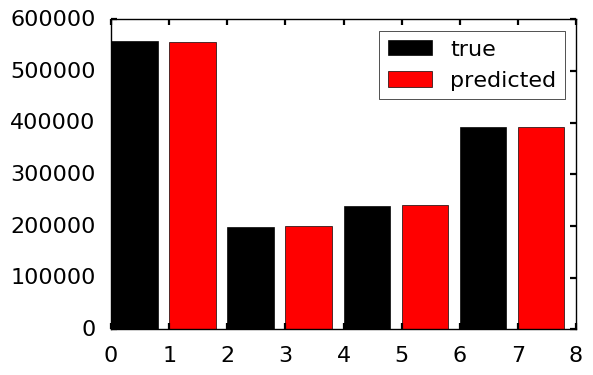

(array([558201,  14425,  19162,  35089,  23495,  32347,  58349,  48075,
        62801, 109150,  58273,  72424, 121909,  27466,  30652,  44207,
         5663,   5367,   6817,  21628,  16679,  17225]), array([ 597953.82265028,   13234.60787206,   17224.77395446,
         33523.19700482,   22132.84322002,   28716.86610803,
         56565.6711931 ,   43980.17814193,   60126.97639476,
        106616.20935736,   55388.73362083,   68587.86228525,
        118978.02385363,   26607.10081879,   28573.58026366,
         42180.15155142,    5418.78716684,    4330.59252777,
          5971.82069197,   23150.91259322,   14461.8764889 ,
         15679.41224091]))


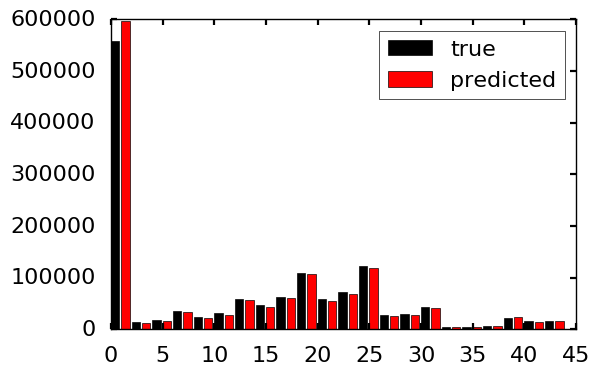

(array([558201, 145964, 182051, 310839,  37496,  41487,  60440,  11758,
        12232,  16521,   2898,   2859,   3849,    909,    803,   1097]), array([ 557589.39835736,  147907.19590749,  185580.64965733,
        308840.25784586,   37362.02685706,   40562.7670745 ,
         58175.16555534,   11530.66456061,   11597.10002226,
         15926.76143905,    2772.11870033,    3102.0047604 ,
          3395.13632921,    2591.94900987,     848.90050638,
          1621.90341698]))


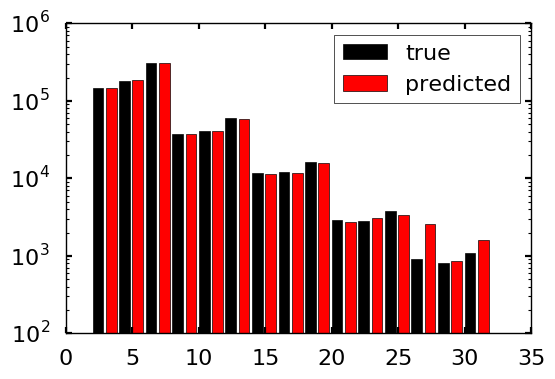

In [13]:
df = effFitter.df 
naive_closure(df,'class')

naive_closure(df,'recoPtCat')

naive_closure(df,'recoNjets2p5Cat',first=1,logy=True)
